# Chamber Analysis - Interactive Notebook

Dieses Notebook führt die Kammer-Analyse Schritt für Schritt durch und zeigt alle Zwischenergebnisse an.

## 1. Imports und Setup

In [1]:
import json
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os

# Import functions from chamber_analyzer_json
from chamber_analyzer_json import (
    load_json_data,
    create_mesh_from_json,
    mesh_to_voxels,
    voxels_to_depth_image_custom_direction,
    create_object_boundary_mask,
    detect_contours_from_depth,
    calculate_chamber_center_for_point,
    plot_contours,
    close_contours_with_boundary,
    filter_nested_contours_with_hierarchy
)

# Matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 2. Lade JSON-Datei

In [2]:
# Wähle JSON-Datei
json_file_path = "C:/Users/LocalUser/Desktop/ConnectionPoins/DataSet/PXC.3036550_ElectricalTerminal_ElectricalTerminal.json"  # Passe Pfad an!

# Lade Daten
part_data = load_json_data(json_file_path)

print(f"PartNr: {part_data.get('PartNr', 'unknown')}")
print(f"ConnectionPoints: {len(part_data.get('ConnectionPoints', []))}")
print(f"Points in Mesh: {len(part_data.get('Graphic3d', {}).get('Points', []))}")
print(f"Indices in Mesh: {len(part_data.get('Graphic3d', {}).get('Indices', []))}")

Loaded: PXC.3036550 - 965 points, 2 connection points
PartNr: PXC.3036550
ConnectionPoints: 2
Points in Mesh: 965
Indices in Mesh: 5766


## 3. Erstelle Mesh und Voxelisierung

In [3]:
# Erstelle Mesh aus JSON
mesh = create_mesh_from_json(part_data)
print(f"Mesh created: {len(mesh.vertices)} vertices, {len(mesh.triangles)} triangles")

# Konvertiere zu Voxeln
voxel_resolution = 800
print(f"\nVoxelizing mesh with resolution {voxel_resolution}...")
voxel_grid = mesh_to_voxels(mesh, voxel_resolution=voxel_resolution)
print(f"Voxel grid created")

Created mesh: 961 vertices, 1922 faces
Mesh created: 961 vertices, 1922 triangles

Voxelizing mesh with resolution 800...
Converting mesh to voxels (resolution: 800)
Voxel size: 0.076918
Voxel grid created: 1322662 voxels
Voxel grid created


## 4. Wähle Connection Point für Analyse

In [4]:
# Liste alle Connection Points
connection_points = part_data.get('ConnectionPoints', [])
for cp in connection_points:
    print(f"CP {cp['Index']}: {cp['Name']} - Position: ({cp['Point']['X']:.2f}, {cp['Point']['Y']:.2f}, {cp['Point']['Z']:.2f})")

# Wähle Connection Point für Analyse
cp_index = 0  # Ändere dies für andere Connection Points
cp = connection_points[cp_index]

print(f"\n=== Analyzing CP {cp['Index']}: {cp['Name']} ===")

CP 0:  - Position: (15.88, 29.70, -2.85)
CP 1:  - Position: (-32.03, 29.70, -2.85)

=== Analyzing CP 0:  ===


## 5. Erstelle Tiefenbild

InsertDirection: [0.000, 1.000, 0.000]
Creating depth image in direction [0.000, 1.000, 0.000]
  Region: 10.0mm x 10.0mm um Anschlusspunkt
  Filtered voxels: 148877 / 1322662 (11.3%)
  Depth image resolution: 132 x 132
  Depth image created: (132, 132), 60.4% coverage


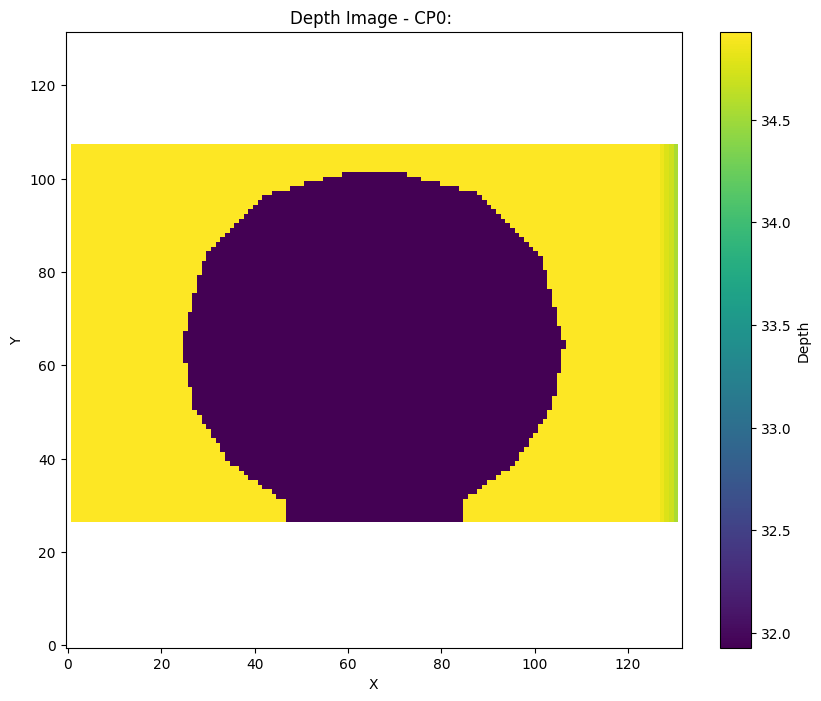

Depth image shape: (132, 132)
Extent: U=[10.88, 20.88], V=[-2.15, 7.85]


In [19]:
# Lese InsertDirection
insert_dir = cp.get('InsertDirection', {'X': 0.0, 'Y': 0.0, 'Z': 1.0})
direction_vector = np.array([insert_dir['X'], insert_dir['Y'], insert_dir['Z']])
direction_vector = direction_vector / np.linalg.norm(direction_vector)

print(f"InsertDirection: [{direction_vector[0]:.3f}, {direction_vector[1]:.3f}, {direction_vector[2]:.3f}]")

# Lese Connection Point Position
cp_pos = cp.get('Point', {'X': 0.0, 'Y': 0.0, 'Z': 0.0})
connection_point_pos = np.array([cp_pos['X'], cp_pos['Y'], cp_pos['Z']])

# Erstelle Tiefenbild (10mm x 10mm Region)
depth_image, extent = voxels_to_depth_image_custom_direction(
    voxel_grid,
    direction_vector,
    connection_point_pos,
    region_size_mm=10.0
)

# Visualisiere Tiefenbild
extent_tuple, transform_info = extent
depth_display = np.ma.masked_invalid(depth_image)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(depth_display, origin='lower', cmap='viridis')
im.cmap.set_bad(color='white')
plt.colorbar(im, ax=ax, label='Depth')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Depth Image - CP{cp["Index"]}: {cp["Name"]}')
plt.show()

print(f"Depth image shape: {depth_image.shape}")
print(f"Extent: U=[{extent_tuple[0]:.2f}, {extent_tuple[1]:.2f}], V=[{extent_tuple[2]:.2f}, {extent_tuple[3]:.2f}]")

## 6. Erstelle Object Boundary

boundary kernel
[[1 1 1]
 [1 1 1]
 [1 1 1]]


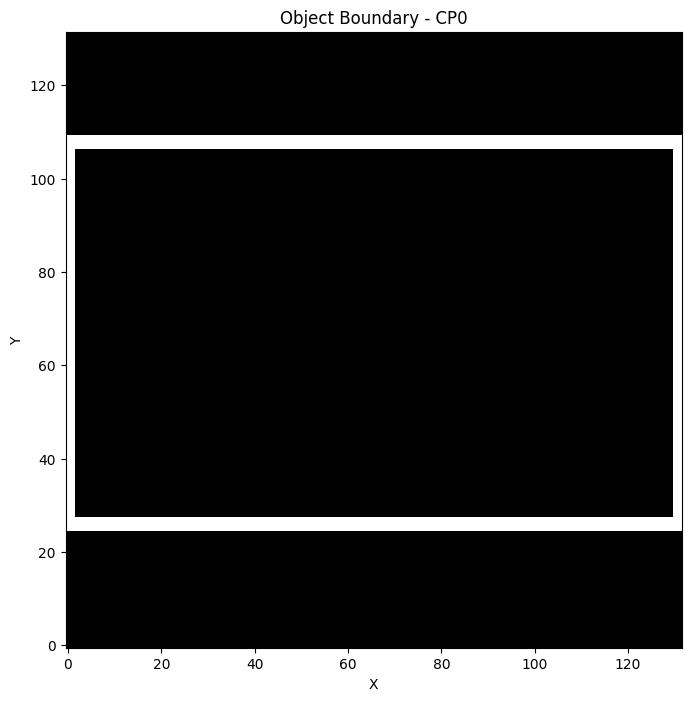

255
0


In [20]:
# Erstelle Object Boundary Mask
valid_mask = ~np.isnan(depth_image)

# Erweitere valid_mask um 1 Pixel (Dilation)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
print("boundary kernel")
print(kernel)
valid_dilated = cv2.dilate(valid_mask.astype(np.uint8), kernel, iterations=1)

# Rand = Pixel die in dilated sind, aber nicht in original
# Das sind NaN-Pixel mit gültigen Nachbarn
object_boundary = ((valid_dilated == 1) & (valid_mask == 0)).astype(np.uint8) * 255
object_boundary = cv2.dilate(object_boundary, kernel, iterations=1)

# Visualisiere
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(object_boundary, origin='lower', cmap='gray')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Object Boundary - CP{cp["Index"]}')
plt.show()


print(np.max(object_boundary))
print(np.min(object_boundary)) 

## 7. Berechne Gradienten

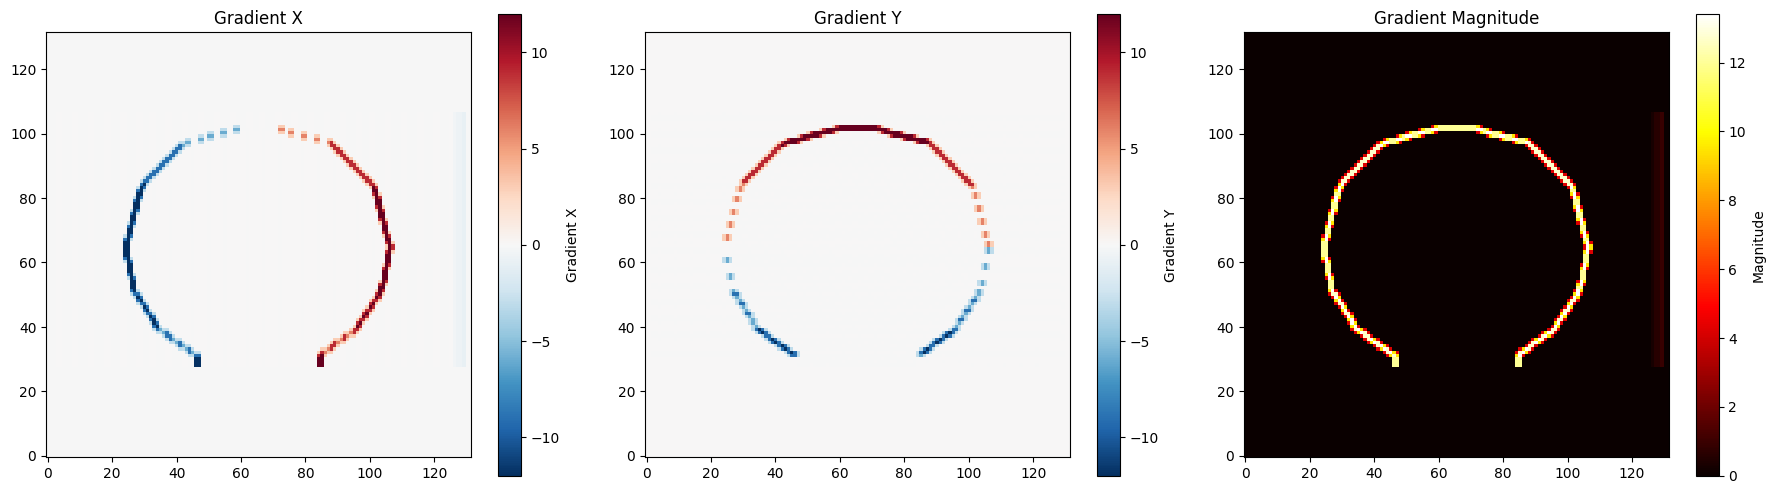

In [21]:
# Berechne Gradienten
valid_mask = ~np.isnan(depth_image)
depth_filled = depth_image.copy()
depth_filled[~valid_mask] = 0

grad_x = cv2.Sobel(depth_filled, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(depth_filled, cv2.CV_64F, 0, 1, ksize=3)

# Setze invalide Gradienten außerhalb des Objekts auf 0
grad_x[~valid_mask] = 0
grad_y[~valid_mask] = 0

# Setze Rand Gradienten auf 0
grad_x[object_boundary == 255] = 0
grad_y[object_boundary == 255] = 0

# calculate magnitute
gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
gradient_magnitude[~valid_mask] = 0

# Visualisiere alle drei
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im1 = axes[0].imshow(grad_x, origin='lower', cmap='RdBu_r')
plt.colorbar(im1, ax=axes[0], label='Gradient X')
axes[0].set_title('Gradient X')

im2 = axes[1].imshow(grad_y, origin='lower', cmap='RdBu_r')
plt.colorbar(im2, ax=axes[1], label='Gradient Y')
axes[1].set_title('Gradient Y')

im3 = axes[2].imshow(gradient_magnitude, origin='lower', cmap='hot')
plt.colorbar(im3, ax=axes[2], label='Magnitude')
axes[2].set_title('Gradient Magnitude')

plt.tight_layout()
plt.show()

## Binary Image

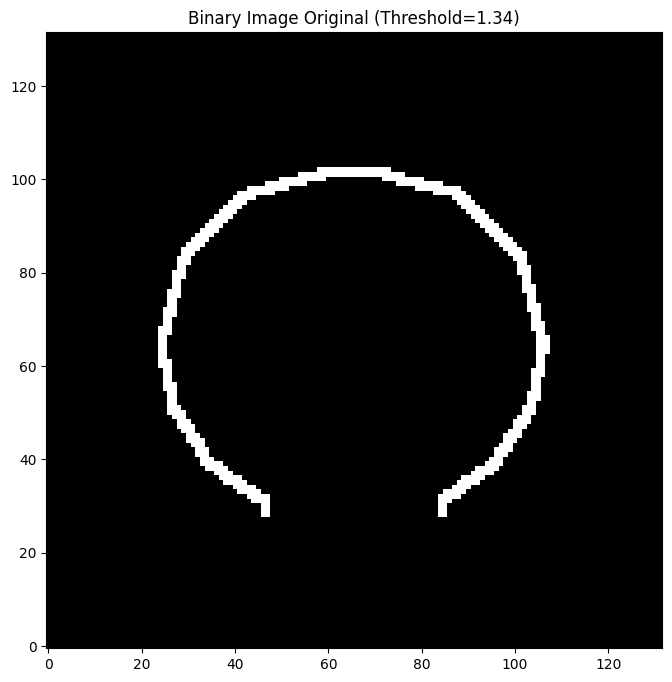

In [22]:
# Threshold für Binary Image
threshold_factor = 0.1
threshold = threshold_factor * np.max(gradient_magnitude)
binary_image = (gradient_magnitude > threshold).astype(np.uint8) * 255

# Visualisiere Binary Original
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(binary_image, origin='lower', cmap='gray')
ax.set_title(f'Binary Image Original (Threshold={threshold:.2f})')
plt.show()

## Show binary image & boundaries

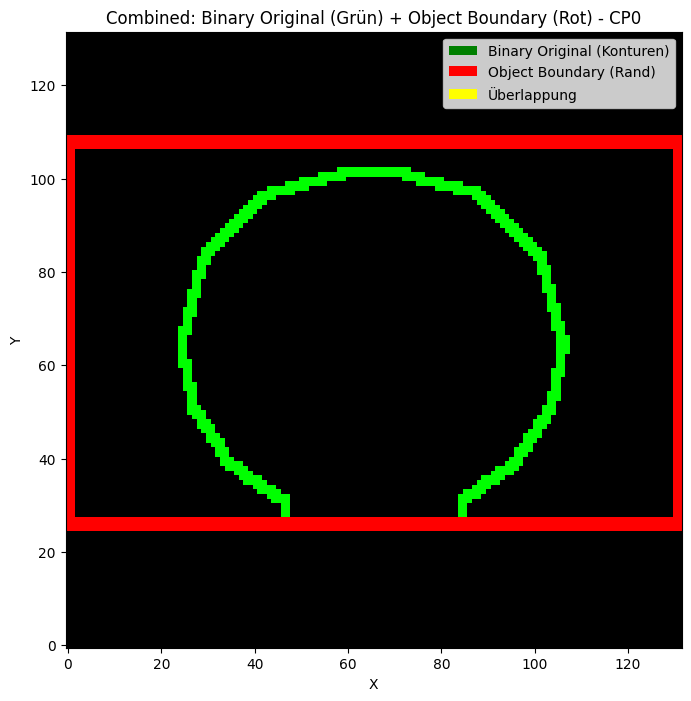

In [23]:
# Erstelle RGB Kombination
combined_image = np.zeros((binary_image.shape[0], binary_image.shape[1], 3), dtype=np.uint8)
combined_image[:, :, 1] = binary_image  # Grün (Kanal 1)
combined_image[:, :, 0] = object_boundary  # Rot (Kanal 0)

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(combined_image, origin='lower')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Combined: Binary Original (Grün) + Object Boundary (Rot) - CP{cp["Index"]}')

legend_elements = [
    Patch(facecolor='green', label='Binary Original (Konturen)'),
    Patch(facecolor='red', label='Object Boundary (Rand)'),
    Patch(facecolor='yellow', label='Überlappung')
]
ax.legend(handles=legend_elements, loc='upper right')
plt.show()

## Contours

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Contours'}, xlabel='X', ylabel='Y'>)

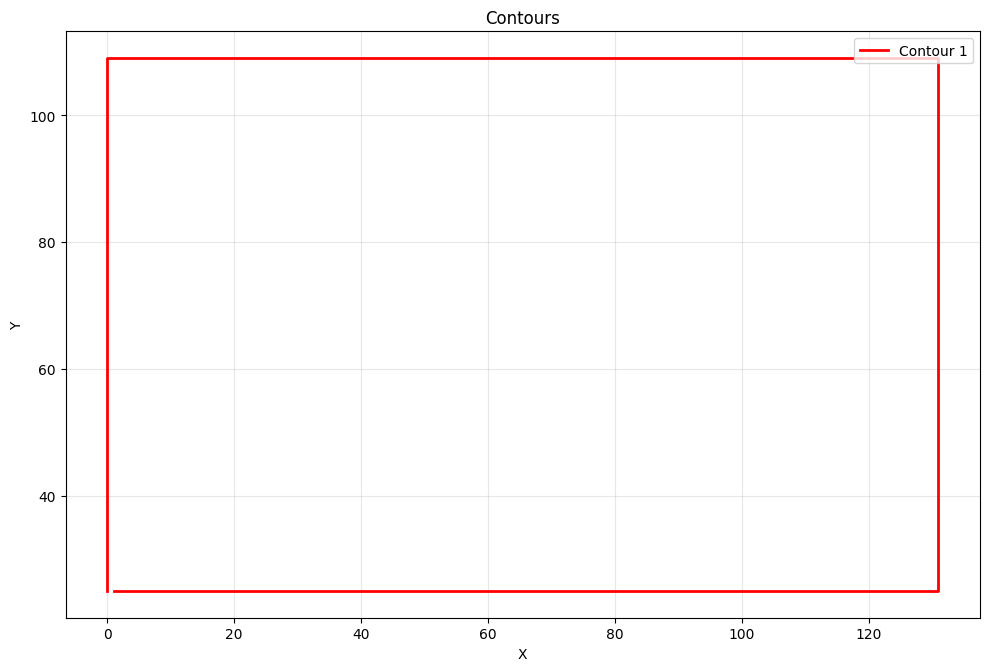

In [10]:
boundary_contours, _ = cv2.findContours(
    object_boundary,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_NONE  # NONE für vollständige Konturen (alle Pixel)
)

plot_contours(boundary_contours)

Initial contours: 1
After size filter: 1


(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Contours'}, xlabel='X', ylabel='Y'>)

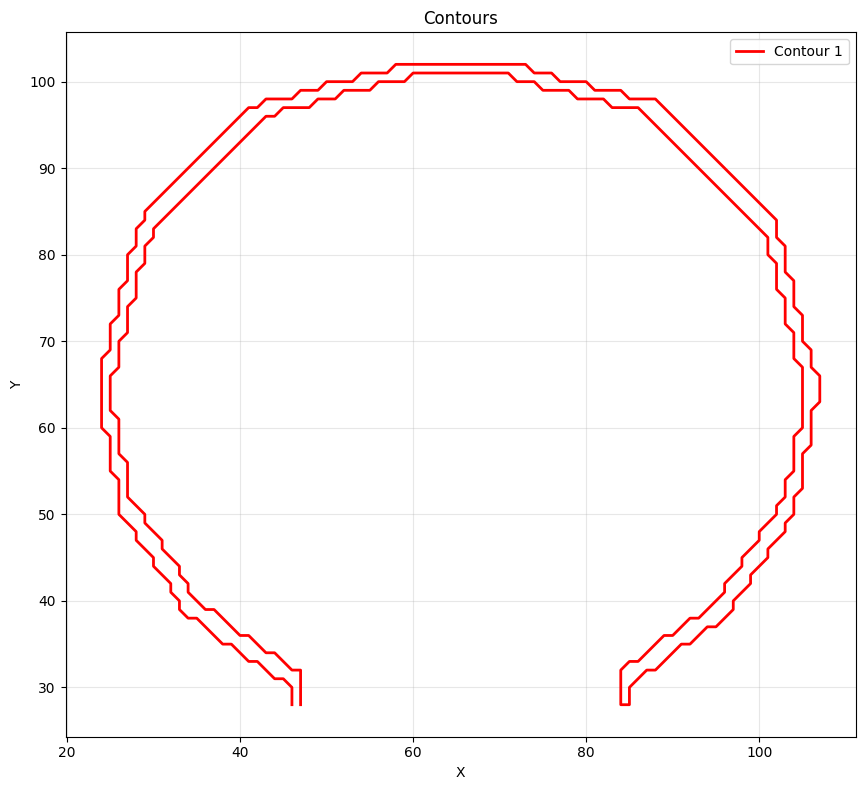

In [11]:

# Erkenne Konturen
contours, hierarchy = cv2.findContours(
    binary_image,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

print(f"Initial contours: {len(contours)}")

# Filtere kleine Konturen
min_contour_area = 20
filtered_contours = [c for c in contours if cv2.contourArea(c) >= min_contour_area]
print(f"After size filter: {len(filtered_contours)}")

plot_contours(contours)

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Contours'}, xlabel='X', ylabel='Y'>)

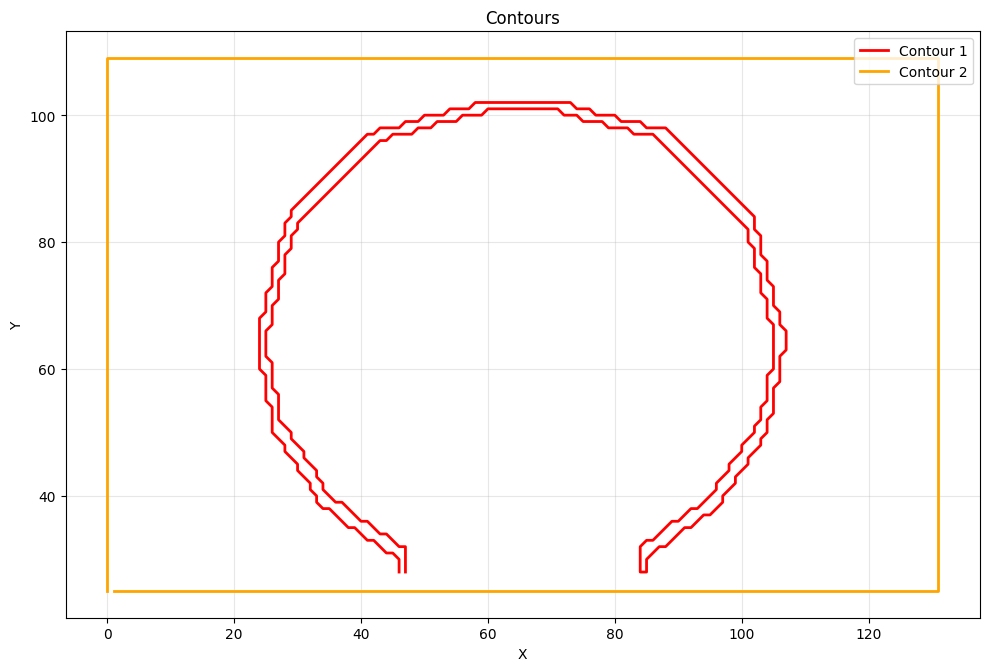

In [12]:
plot_contours(contours + boundary_contours)

## 9. Schließe Konturen mit Object Boundary

  Schließe Konturen mit Objektgrenze...
    Found 1 boundary contours
    Contour 0: 4 neighbor points to boundary
  1 Konturen geschlossen mit boundary
  Neue Konturen nach Schließung: 44
  Filtere verschachtelte Konturen mit OpenCV Hierarchie...
    Entferne verschachtelte Kontur (Kind von C1)
    Entferne verschachtelte Kontur (Kind von C1)
  Verschachtelte Konturen: 3 -> 1 (entfernt: 2)
After boundary closing: 44
Final contours: 1


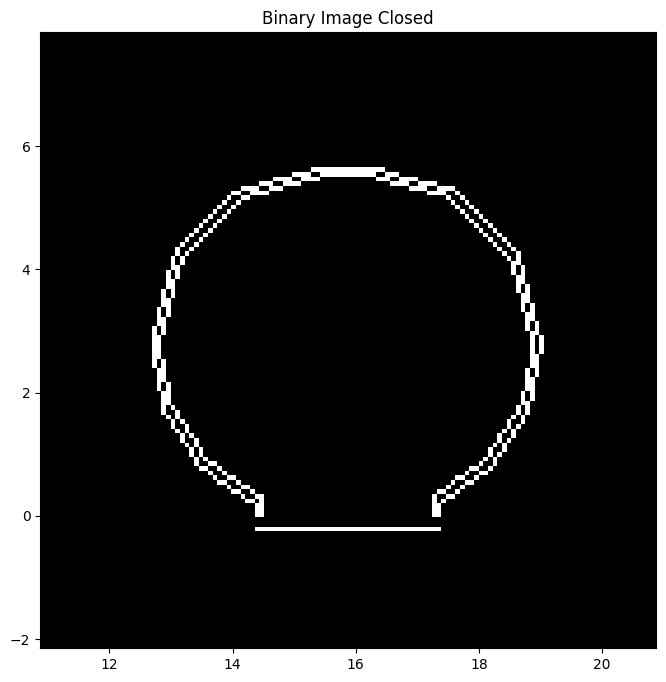

In [13]:
# Schließe Konturen
closed_binary, closed_contours, closed_hierarchy = close_contours_with_boundary(
    filtered_contours, object_boundary
)

# Filtere wieder
closed_filtered = [c for c in closed_contours if cv2.contourArea(c) >= min_contour_area]

# Filtere verschachtelte Konturen
final_contours = filter_nested_contours_with_hierarchy(
    closed_filtered, closed_contours, closed_hierarchy
)

print(f"After boundary closing: {len(closed_contours)}")
print(f"Final contours: {len(final_contours)}")

# Visualisiere Binary Closed
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(closed_binary, extent=extent_tuple, origin='lower', cmap='gray')
ax.set_title('Binary Image Closed')
plt.show()

## 11. Berechne Chamber Center

In [14]:
# Berechne Chamber Center
chamber_center = calculate_chamber_center_for_point(
    cp,
    final_contours,
    depth_image,
    extent,
    direction_vector
)

if chamber_center['chamber_center'] is not None:
    cc = chamber_center['chamber_center']
    print(f"Chamber Center found:")
    print(f"  X: {cc['X']:.4f}")
    print(f"  Y: {cc['Y']:.4f}")
    print(f"  Z: {cc['Z']:.4f}")
else:
    print("No chamber center found")

  Connection point pixel: (65, 65)
No chamber center found


## 12. Finale Analyse Visualisierung

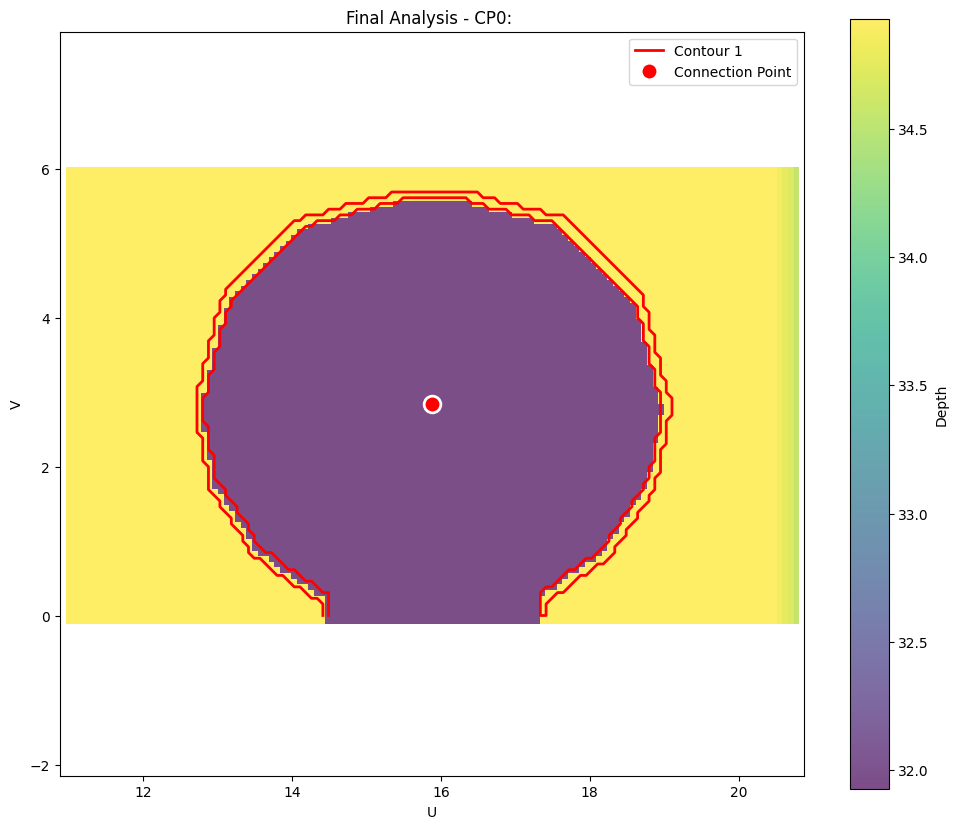

In [15]:
# Erstelle finale Visualisierung
depth_display = np.ma.masked_invalid(depth_image)

u_min, u_max, v_min, v_max = extent_tuple
u_axis = transform_info['u_axis']
v_axis = transform_info['v_axis']
voxel_size = transform_info['voxel_size']

# Connection Point Position in U/V
cp_point = cp['Point']
cp_world = np.array([cp_point['X'], cp_point['Y'], cp_point['Z']])
cp_u = np.dot(cp_world, u_axis)
cp_v = np.dot(cp_world, v_axis)

# Chamber Center Position
cc_u, cc_v = None, None
if chamber_center.get('chamber_center') is not None:
    cc = chamber_center['chamber_center']
    cc_world = np.array([cc['X'], cc['Y'], cc['Z']])
    cc_u = np.dot(cc_world, u_axis)
    cc_v = np.dot(cc_world, v_axis)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(depth_display, extent=extent_tuple, origin='lower', cmap='viridis', alpha=0.7)
im.cmap.set_bad(color='white')
plt.colorbar(im, ax=ax, label='Depth')

# Zeichne Konturen
colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'magenta', 'pink']
for i, contour in enumerate(final_contours):
    contour_squeezed = contour.squeeze()
    if len(contour_squeezed.shape) == 1:
        continue

    contour_u = u_min + contour_squeezed[:, 0] * voxel_size
    contour_v = v_min + contour_squeezed[:, 1] * voxel_size

    color = colors[i % len(colors)]
    ax.plot(contour_u, contour_v, color=color, linewidth=2, label=f'Contour {i+1}')

# Zeichne Connection Point
ax.plot(cp_u, cp_v, 'ro', markersize=12, markeredgecolor='white', markeredgewidth=2, zorder=10, label='Connection Point')

# Zeichne Chamber Center
if cc_u is not None and cc_v is not None:
    ax.plot(cc_u, cc_v, 'g^', markersize=14, markeredgecolor='white', markeredgewidth=2, zorder=10, label='Chamber Center')

ax.set_xlabel('U')
ax.set_ylabel('V')
ax.set_title(f'Final Analysis - CP{cp["Index"]}: {cp["Name"]}')
ax.legend()
plt.show()